# Gaussian Processes meets pyMC3

In [2]:
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

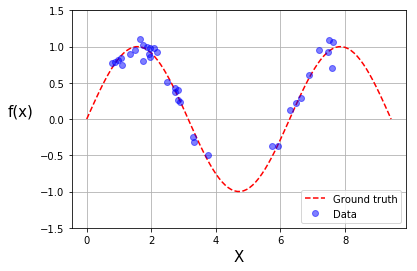

In [14]:
np.random.seed(42)
N = 50
plt.figure(figsize=(6,4))

x_truth = np.linspace(0,3*np.pi,100)
x = np.sort(np.random.uniform(0.2*np.pi,2.5*np.pi,N)) 

mask = np.logical_not(np.logical_and(x > 3.8, x < 5.6))
x = x[mask]

N = np.sum(mask)
f = np.sin

sigma2 = 0.1
noise = np.random.normal(0,sigma2,N)
y = f(x) + noise

plt.plot(x_truth, f(x_truth), 'r--', label='Ground truth')
plt.plot(x, y, 'bo', label='Data', alpha=0.5)

plt.xlabel('X', fontsize=15)
plt.ylabel('f(x)', rotation=0, fontsize=15, labelpad=20)
plt.ylim(-1.5,1.5)
plt.grid()
_=plt.legend(loc=4)

### Parametrized Kernel

<br>
<img src='K.png' width=300>
<br><hr>

In [4]:
def squared_dist(x,y): #
    #       N,1           1,M
    return (x[:,None] - y[None])**2 # N,M

In [5]:
def s_dist(X,Y):
    # N,1,D   1,M,D
    return np.square(X[:,None] - Y[None]).sum(2) # -> N,M

In [6]:
from theano.tensor.nlinalg import matrix_inverse as inv
from pymc3.math import dot, exp

GP = pm.Model()

x_test = x_truth

# Compute the Distances

D_oo = squared_dist(x_test, x_test)
D_xo = squared_dist(x, x_test)
D = squared_dist(x,x)

with GP:
    # Define the priors over the Kernel parameters
    eta = pm.Gamma('eta', 5,1)
    rho = pm.Gamma('rho', 5,1)
    sigma = pm.Gamma('sigma', 5,1)
    
    # Build the Kernel
    K = tt.fill_diagonal(eta*exp(-rho*D), eta + sigma)
    K_inv = inv(K)
    
    # Set observations to be a Gaussian process
    y_hat = pm.MvNormal('y', np.zeros(N), K, observed = y)
    
    # Define Kernels for the test points
    K_xo = eta * exp(-rho*D_xo)
    
    #K_oo = eta * exp(-rho*D_oo)
    K_oo = tt.fill_diagonal(eta*exp(-rho*D_oo), eta + sigma)
    
    # Compute the posterior mean
    mu_post = pm.Deterministic('mu_post', dot(dot(K_xo.T,K_inv),y) )
    # Compute the posterior covariance matrix
    Sigma_post = pm.Deterministic('Sigma_post', K_oo - dot(dot(K_xo.T,K_inv),K_xo) )

<br>
<img src='GP.png' ,width=350>

## Sample the GP model

In [7]:
with GP:
    trace = pm.sample(draws=1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, rho, eta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:31<00:00, 189.41draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


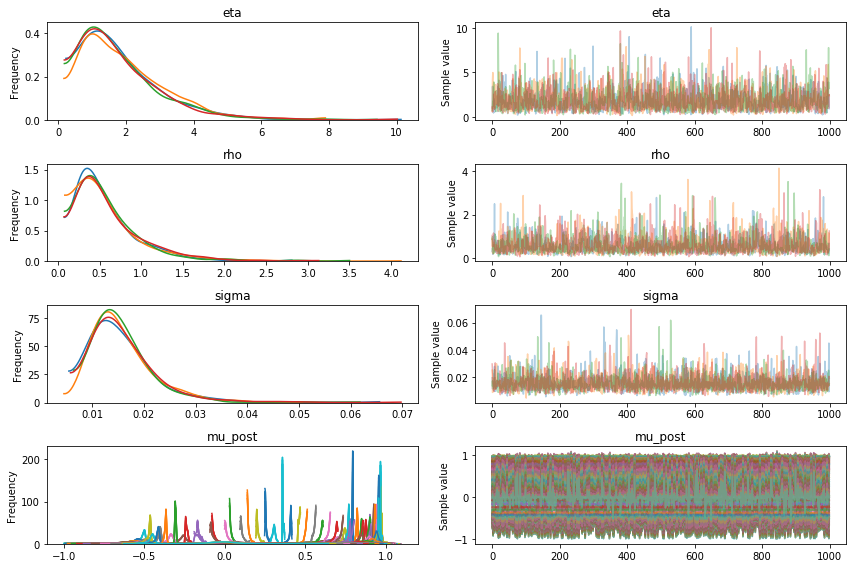

In [8]:
var = ['eta','rho','sigma','mu_post']
_= pm.traceplot(trace, var)

In [9]:
pm.stats.summary(trace,var).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta,1.871,1.233,0.025,0.220,4.216,2431.732,1.001
rho,0.597,0.413,0.009,0.094,1.392,2063.451,1.000
sigma,0.016,0.006,0.000,0.006,0.028,3086.265,1.000
mu_post__0,0.522,0.113,0.002,0.266,0.707,2424.221,1.001
mu_post__1,0.552,0.099,0.002,0.322,0.707,2590.189,1.000
...,...,...,...,...,...,...,...
mu_post__95,0.075,0.177,0.003,-0.247,0.523,3635.589,1.000
mu_post__96,0.044,0.170,0.003,-0.303,0.451,3667.113,1.000
mu_post__97,0.018,0.163,0.003,-0.301,0.423,3586.342,1.000
mu_post__98,-0.003,0.156,0.002,-0.323,0.389,3468.316,1.000


In [10]:
mu_post = trace["mu_post"]
Sigma_post = trace["Sigma_post"]
S,N = mu_post.shape
print(S,N)

4000 100


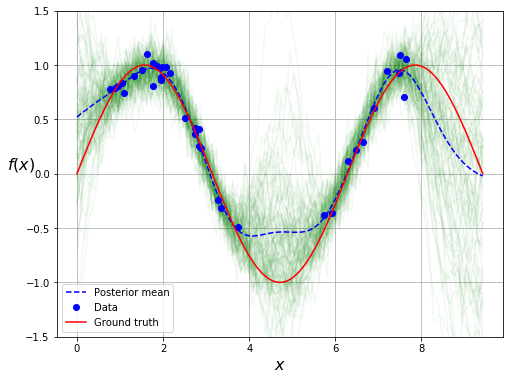

In [23]:
N_samples = 100
idx = np.random.randint(low = 0, high=S+1, size= N_samples)

mu_p = mu_post[idx]
Sigma_p = Sigma_post[idx]

mu = mu_post.mean(0)
sig = Sigma_post.mean(0)

plt.figure(figsize=(8,6))
for i in range(N_samples):
    y_pred = np.random.multivariate_normal(mu_p[i], Sigma_p[i])
    plt.plot(x_test, y_pred, 'g-', alpha=0.05)

plt.plot(x_test,mu,'b--', label='Posterior mean')
plt.plot(x,y,'bo', label='Data')
plt.ylim(-1.5,1.5)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.plot(x_truth, f(x_truth), 'r-', label='Ground truth')
plt.grid()
_=plt.legend()